In [1]:
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\chao_gu\Anaconda3\envs\stats\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
plt.style.use('fivethirtyeight')

#### import data file

In [2]:
df = pd.read_csv('./Data/Police_Incidents_Final.csv')

C:\Users\chao_gu\Anaconda3\envs\stats\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.iloc[0]

Incident Number                                090033416
Date Occurred                                 2009-04-02
UCR                                                 1823
UCR Description                  Narco Possess-Synthetic
Location                        1600BLK OCEAN FRONT WALK
Gang Related                                       False
Latitude                                         34.0103
Longitude                                       -118.496
Map Point          (34.0102977457032, -118.495738552074)
Line_Open                                          False
Month                                                  4
Year                                                2009
Day_Of_Week                                            3
Day_Delta                                          -2605
UCR Level 2                                    Narcotics
UCR Level 1                                  Non-Violent
one_mile                                               1
half_mile                      

#### data processing

In [4]:
import datetime

In [5]:
df['Incident Date'] = df['Date Occurred'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

In [6]:
df['Incident Date'].isnull().sum()

0

In [15]:
df_month=df.groupby(['Year','Month'])['Month'].count()

In [16]:
time = [(lambda year,month: datetime.datetime(year,month,1))(year,month) for year,month in df_month.index.values]
time_index = pd.Series(time)
df_month.index = time_index

In [83]:
from statsmodels.tsa.stattools import adfuller
def dickey_fuller_test(df):
    df_test = adfuller(df,autolag = 'AIC')
    test_result = pd.Series(df_test[0:4],
                       index = ['Test Statistic',
                               'p-vale',
                               '#Lags Used',
                               'Mumber of Observation Used'])
    for key,value in df_test[4].items():
        test_result['Critical Value (%s)'%key] = value
    return test_result

In [123]:
def plot_stat_graph(df,window = 12):
    fig = plt.figure(figsize=(20,10))
    rolstd = pd.Series.rolling(df_month,window = window).std()
    rolmean = pd.Series.rolling(df_month,window = window).mean()
    
    plt.plot(df_month.index,df_month,color = 'blue',label = 'Original')
    plt.plot(rolstd.index,rolstd,color = 'orange',label = 'Rolling Std')
    plt.plot(rolmean.index,rolmean,color = 'red',label = 'Rolling Mean')
    
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    
    plt.show()

In [124]:
def data_info(df,window = 12):
    plot_stat_graph(df,window)
    result = dickey_fuller_test(df)
    print(result)
    return

#### Data Analysis

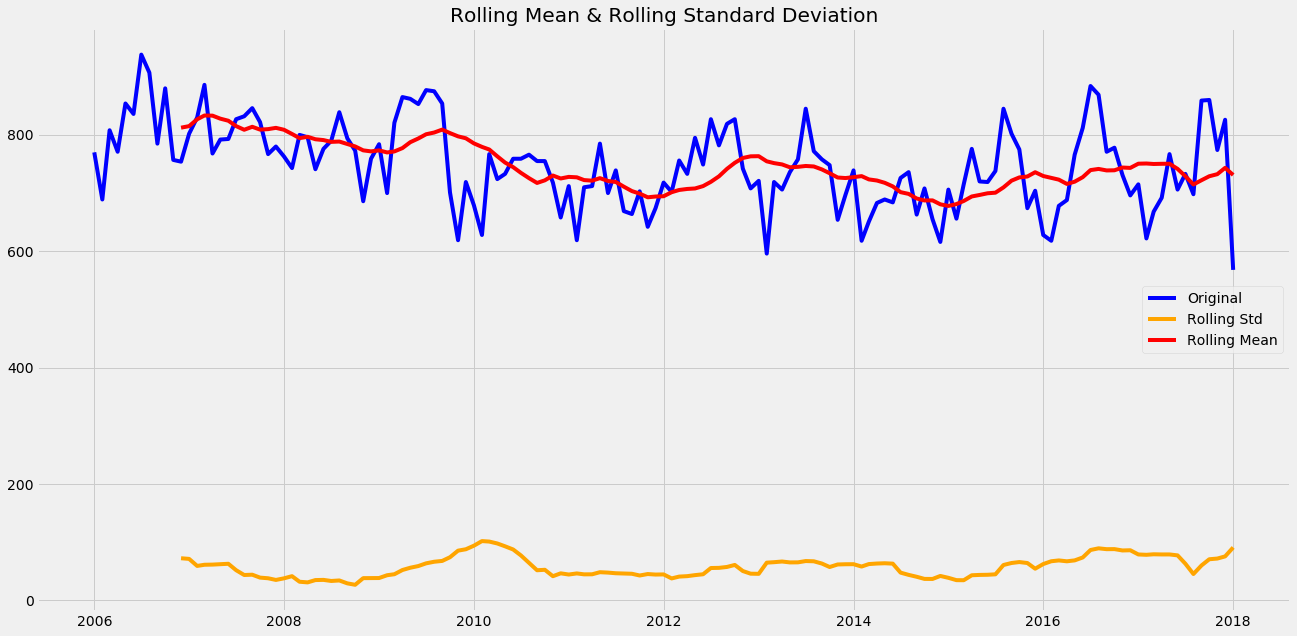

Test Statistic                 -1.776795
p-vale                          0.392042
#Lags Used                     11.000000
Mumber of Observation Used    133.000000
Critical Value (1%)            -3.480500
Critical Value (5%)            -2.883528
Critical Value (10%)           -2.578496
dtype: float64


In [125]:
data_info(df_month)

#### autocorrelation 

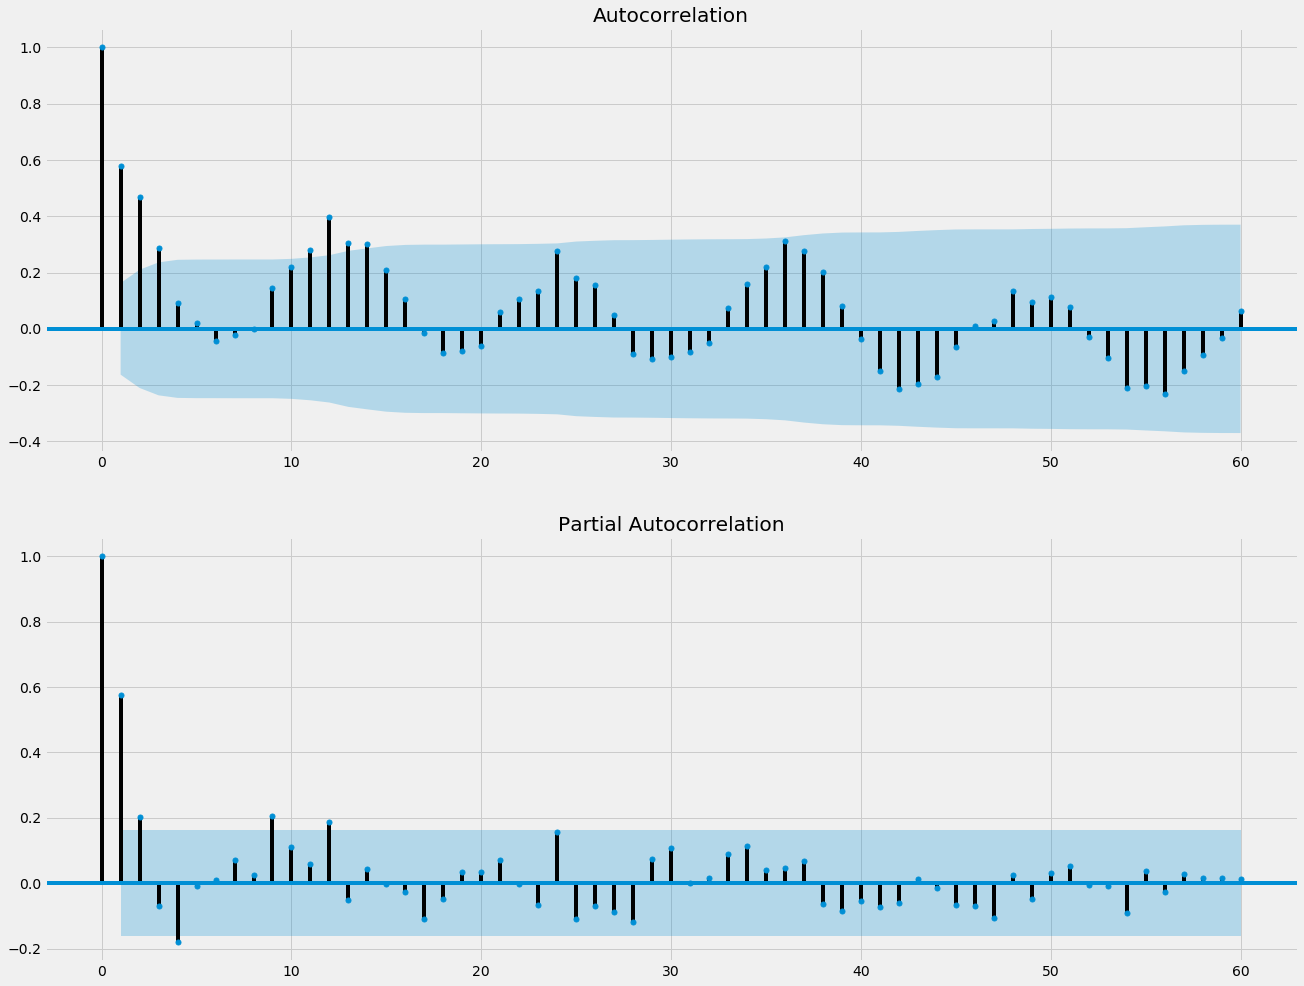

In [44]:
fig = plt.figure(figsize=(20,16))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_month,lags =60, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_month,lags =60, ax = ax2)

### ARIMA model

In [46]:
res_df = sm.tsa.arma_order_select_ic(df_month,ic='aic',trend='nc')

C:\Users\chao_gu\Anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\chao_gu\Anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [47]:
res_df

{'aic':              0            1            2
 0          NaN  2159.204304  2021.289448
 1  1628.474126  1614.697579  1615.897489
 2  1613.888161  1615.792365  1618.695931
 3  1615.763515  1616.648643  1618.055480
 4  1617.249516  1618.183650  1620.990569, 'aic_min_order': (2, 0)}

In [48]:
# the best pair is p = 2, q = 0
from statsmodels.tsa.arima_model import ARIMA

In [173]:
ARIMA_2_1_0 = ARIMA(df_month.astype(np.float64),order = (3,2,2)).fit(disp=-1)

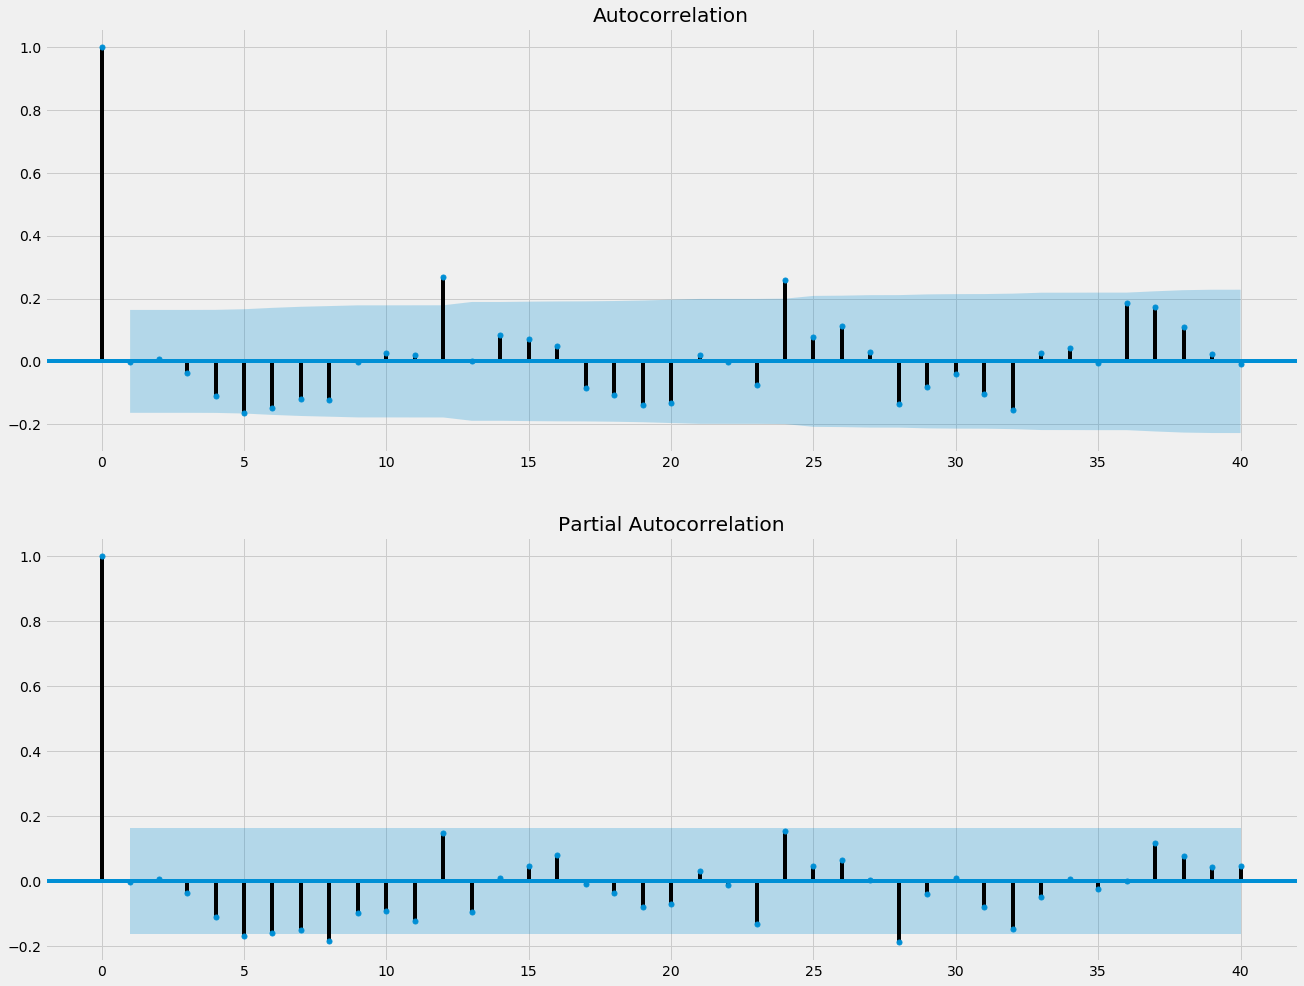

In [147]:
resid = ARIMA_2_1_0.resid
fig = plt.figure(figsize = (20,16))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values,lags =40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid,lags =40, ax = ax2)

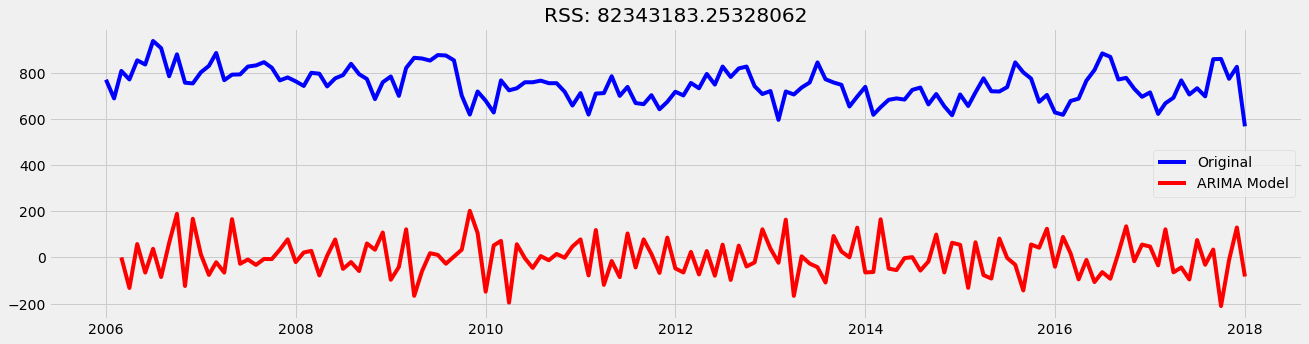

In [148]:
fig = plt.figure(figsize=(20,5))
result = ARIMA_2_1_0.fittedvalues
plt.plot(df_month.index,df_month,color = 'blue',label = 'Original')
plt.plot(result,color = 'red',label = 'ARIMA Model')
plt.title('RSS: {}'.format(sum((result-df_month).dropna()**2)))
plt.legend()
plt.show()

In [133]:
ARIMA_2_1_0.predict('2017-06-01','2017-12-01')

2017-06-01    -95.606996
2017-07-01     75.237662
2017-08-01    -31.845226
2017-09-01     33.995481
2017-10-01   -210.853054
2017-11-01    -11.169216
2017-12-01    129.673048
Freq: MS, dtype: float64

### SARIMA Model

In [138]:
SARIMA_2_1_0_111 = sm.tsa.statespace.SARIMAX(df_month,
                                order = (2,1,0),
                                seasonal_order = (1,1,1,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False).fit()

In [139]:
SARIMA_2_1_0_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Month   No. Observations:                  145
Model:             SARIMAX(2, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -641.158
Date:                            Tue, 13 Feb 2018   AIC                           1292.317
Time:                                    13:36:22   BIC                           1307.200
Sample:                                01-01-2006   HQIC                          1298.364
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3678      0.123     -3.001      0.003      -0.608      -0.128
ar.L2         -0.1590      0.139     -1.144      0.252      -0.431       0.113
ar.S.L12      -0.0214      0.095     -0.225      0.822      -0.208       0.165
ma.S.L12      -0.8380      0.158     -5.287      0.000      -1.149      -0.527
sigma2      2864.8825    240.033     11.935      0.000    2394.426    3335.339
===================================================================================
Ljung-Box (Q):                       30.68   Jarque-Bera (JB):               103.65
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.75
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

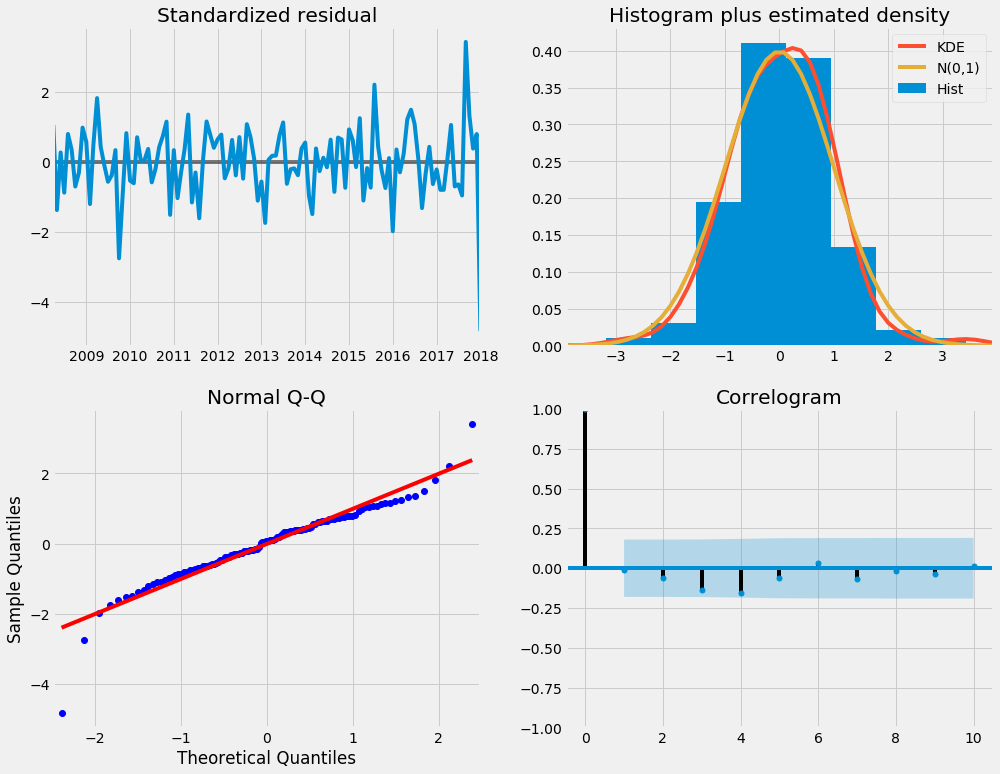

In [141]:
SARIMA_2_1_0_111.plot_diagnostics(figsize = (15,12))
plt.show()

In [149]:
pred = SARIMA_2_1_0_111.get_prediction(start = datetime.datetime(2015,1,1), dynamic = False)
pred_ci = pred.conf_int()

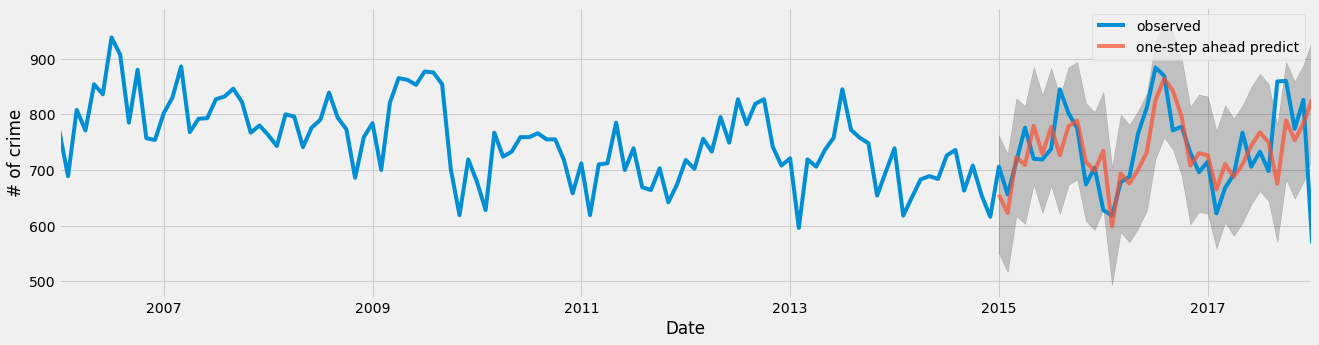

In [152]:
fig = plt.figure(figsize=(20,5))
ax = df_month.plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'one-step ahead predict', alpha = .7)

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('# of crime')
plt.legend()
plt.show()

### grid search for SARIMA 

In [158]:
modelselection = pd.DataFrame(columns = ['order','seasonal','aic'])

In [161]:
p=q=range(1,4)
d=D=1
pq = list(itertools.product(p,q))
pdq = [(x[0],d,x[1]) for x in pq]
seasonal_pdq = [(x[0],D,x[1],12) for x in pq]

In [164]:
%%time
warnings.filterwarnings('ignore') #ignore warning message

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_month,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,  
                                            enforce_invertibility = False)
            result = mod.fit().aic
            data = pd.DataFrame([[str(param),str(param_seasonal),result]],
                                columns = modelselection.columns)
            modelselection = modelselection.append(data, ignore_index = True)

        except:
#             print('error')
            continue


Wall time: 9min 45s


In [165]:
modelselection.loc[modelselection['aic'].idxmin()]

order           (3, 1, 3)
seasonal    (3, 1, 1, 12)
aic               1014.07
Name: 78, dtype: object

In [168]:
SARIMA_313_311 = sm.tsa.statespace.SARIMAX(df_month,
                                order = (3,1,3),
                                seasonal_order = (3,1,1,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False).fit()

In [193]:
SARIMA_313_311.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Month   No. Observations:                  145
Model:             SARIMAX(3, 1, 3)x(3, 1, 1, 12)   Log Likelihood                -496.036
Date:                            Tue, 13 Feb 2018   AIC                           1014.073
Time:                                    18:10:35   BIC                           1046.817
Sample:                                01-01-2006   HQIC                          1027.378
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7872      0.164      4.797      0.000       0.466       1.109
ar.L2         -0.7884      0.127     -6.204      0.000      -1.037      -0.539
ar.L3          0.3275      0.170      1.921      0.055      -0.007       0.662
ma.L1         -1.1365      0.124     -9.154      0.000      -1.380      -0.893
ma.L2          1.1939      0.390      3.065      0.002       0.430       1.957
ma.L3         -0.9042      0.326     -2.774      0.006      -1.543      -0.265
ar.S.L12      -0.1564      0.149     -1.047      0.295      -0.449       0.136
ar.S.L24      -0.0422      0.129     -0.328      0.743      -0.294       0.210
ar.S.L36      -0.4455      0.093     -4.775      0.000      -0.628      -0.263
ma.S.L12      -0.8218      0.334     -2.461      0.014      -1.476      -0.167
sigma2      2094.2496   1017.301      2.059      0.040     100.376    4088.123
===================================================================================
Ljung-Box (Q):                       30.25   Jarque-Bera (JB):                 4.26
Prob(Q):                              0.87   Prob(JB):                         0.12
Heteroskedasticity (H):               2.11   Skew:                             0.06
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

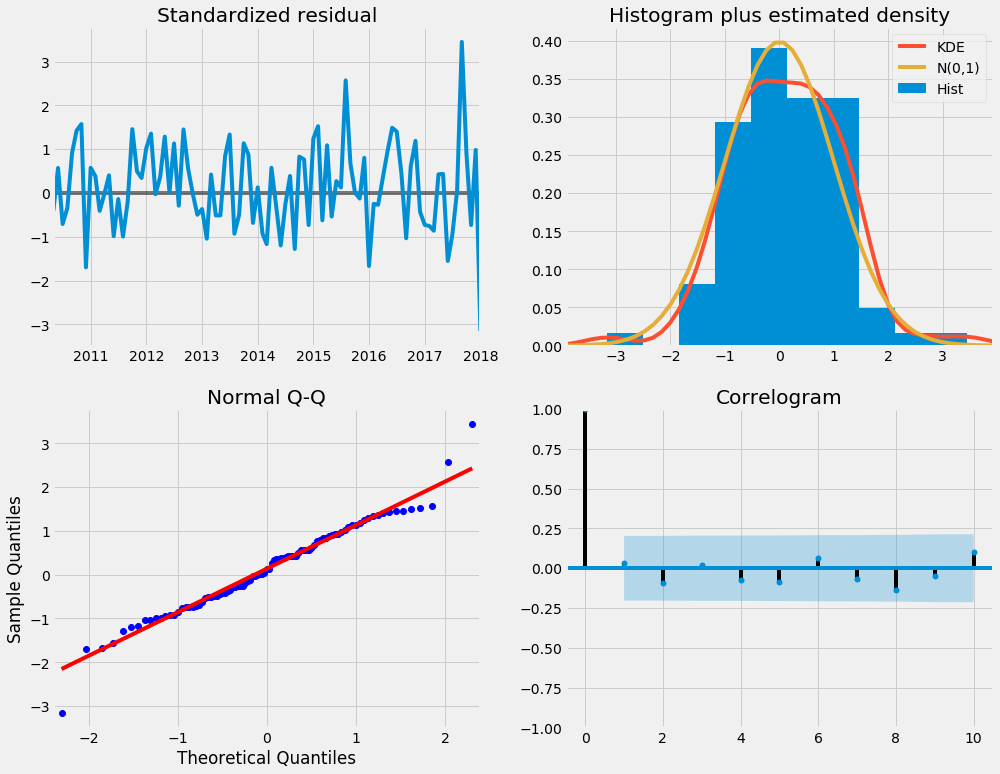

In [235]:
SARIMA_313_311.plot_diagnostics(figsize = (15,12))
plt.show()

In [236]:
pred = SARIMA_313_311.get_prediction(start = datetime.datetime(2015,1,1), dynamic = False)
pred_ci = pred.conf_int()

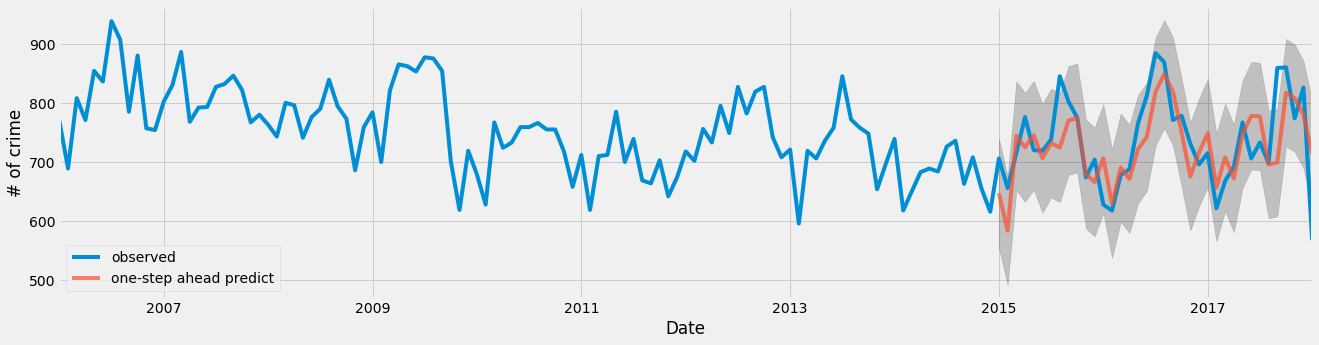

In [237]:
fig = plt.figure(figsize=(20,5))
ax = df_month.plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'one-step ahead predict', alpha = .7)

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('# of crime')
plt.legend()
plt.show()

### difference analysis 

In [41]:
diff = df_month - df_month.shift()
diff = diff.dropna()

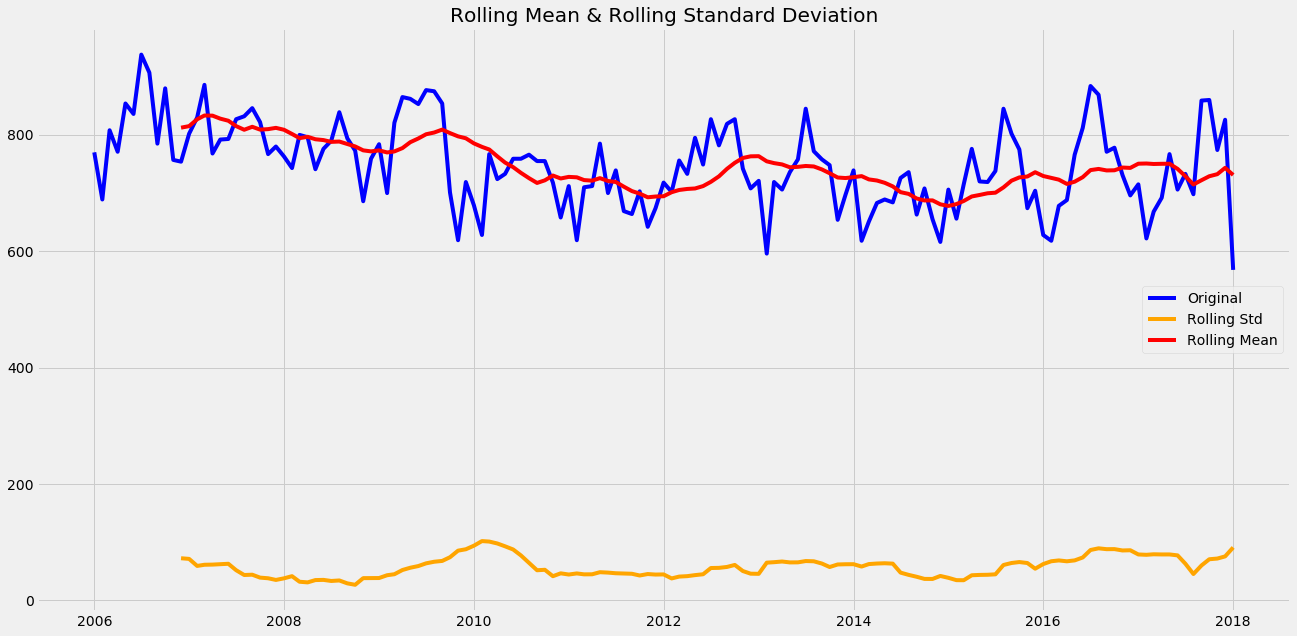

Test Statistic               -7.681705e+00
p-vale                        1.497936e-11
#Lags Used                    1.000000e+01
Mumber of Observation Used    1.330000e+02
Critical Value (1%)          -3.480500e+00
Critical Value (5%)          -2.883528e+00
Critical Value (10%)         -2.578496e+00
dtype: float64


In [174]:
data_info(diff)

### log analysis

In [177]:
logDf = np.log(df_month)

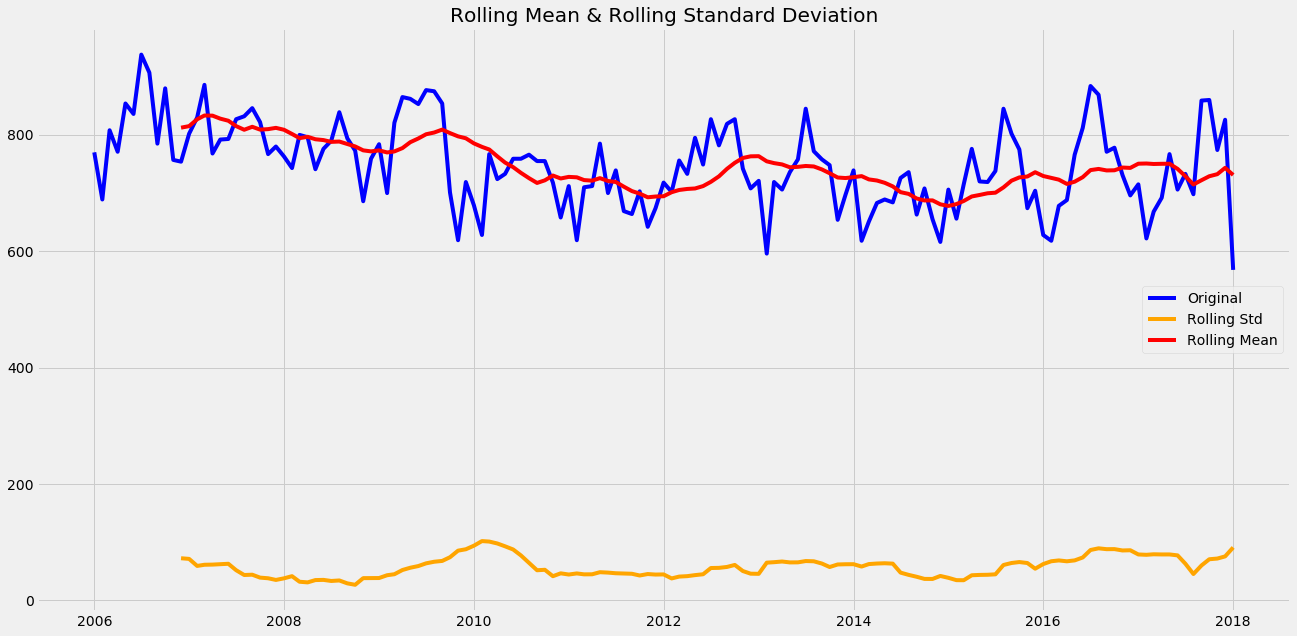

Test Statistic                 -1.724634
p-vale                          0.418467
#Lags Used                     11.000000
Mumber of Observation Used    133.000000
Critical Value (1%)            -3.480500
Critical Value (5%)            -2.883528
Critical Value (10%)           -2.578496
dtype: float64


In [179]:
data_info(logDf)

### log difference analysis 

In [178]:
logDiff = np.log(df_month) - np.log(df_month.shift())
logDiff = logDiff.dropna()

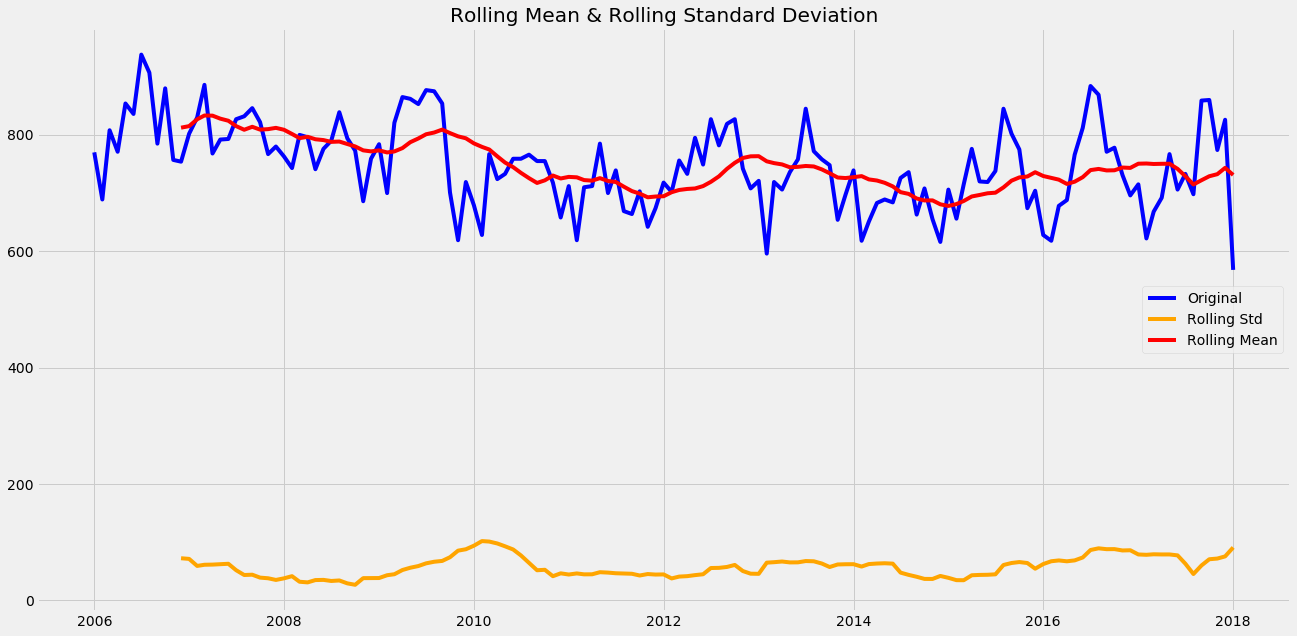

Test Statistic               -7.779308e+00
p-vale                        8.501265e-12
#Lags Used                    1.000000e+01
Mumber of Observation Used    1.330000e+02
Critical Value (1%)          -3.480500e+00
Critical Value (5%)          -2.883528e+00
Critical Value (10%)         -2.578496e+00
dtype: float64


In [175]:
data_info(logDiff)

### use difference for further analysis 

In [197]:
modelselection_diff = pd.DataFrame(columns = ['order','seasonal','aic'])

In [198]:
p=q=range(1,4)
d=D=1
pq = list(itertools.product(p,q))
pdq = [(x[0],d,x[1]) for x in pq]
seasonal_pdq = [(x[0],D,x[1],12) for x in pq]

In [199]:
%%time
warnings.filterwarnings('ignore') #ignore warning message

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diff,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,  
                                            enforce_invertibility = False)
            result = mod.fit().aic
            data = pd.DataFrame([[str(param),str(param_seasonal),result]],
                                columns = modelselection_diff.columns)
            modelselection_diff = modelselection_diff.append(data, ignore_index = True)

        except:
#             print('error')
            continue

Wall time: 8min 44s


In [200]:
modelselection_diff.loc[modelselection_diff['aic'].idxmin()]

order           (3, 1, 2)
seasonal    (3, 1, 1, 12)
aic               1018.67
Name: 69, dtype: object

In [203]:
SARIMA_313_311_diff = sm.tsa.statespace.SARIMAX(diff,
                                order = (3,1,2),
                                seasonal_order = (3,1,1,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False).fit()

In [204]:
SARIMA_313_311_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Month   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(3, 1, 1, 12)   Log Likelihood                -499.334
Date:                            Tue, 13 Feb 2018   AIC                           1018.669
Time:                                    21:00:39   BIC                           1048.367
Sample:                                02-01-2006   HQIC                          1030.737
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2452      0.157      1.563      0.118      -0.062       0.553
ar.L2          0.1084      0.170      0.636      0.525      -0.226       0.442
ar.L3         -0.1702      0.144     -1.183      0.237      -0.452       0.112
ma.L1         -2.1334      0.703     -3.035      0.002      -3.511      -0.756
ma.L2          1.1337      0.812      1.396      0.163      -0.458       2.726
ar.S.L12      -0.5824      0.197     -2.951      0.003      -0.969      -0.196
ar.S.L24      -0.3947      0.148     -2.667      0.008      -0.685      -0.105
ar.S.L36       0.0108      0.010      1.132      0.258      -0.008       0.030
ma.S.L12      -0.2776      0.231     -1.201      0.230      -0.730       0.175
sigma2      2128.0777   1480.963      1.437      0.151    -774.557    5030.712
===================================================================================
Ljung-Box (Q):                       24.19   Jarque-Bera (JB):                10.63
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -0.16
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

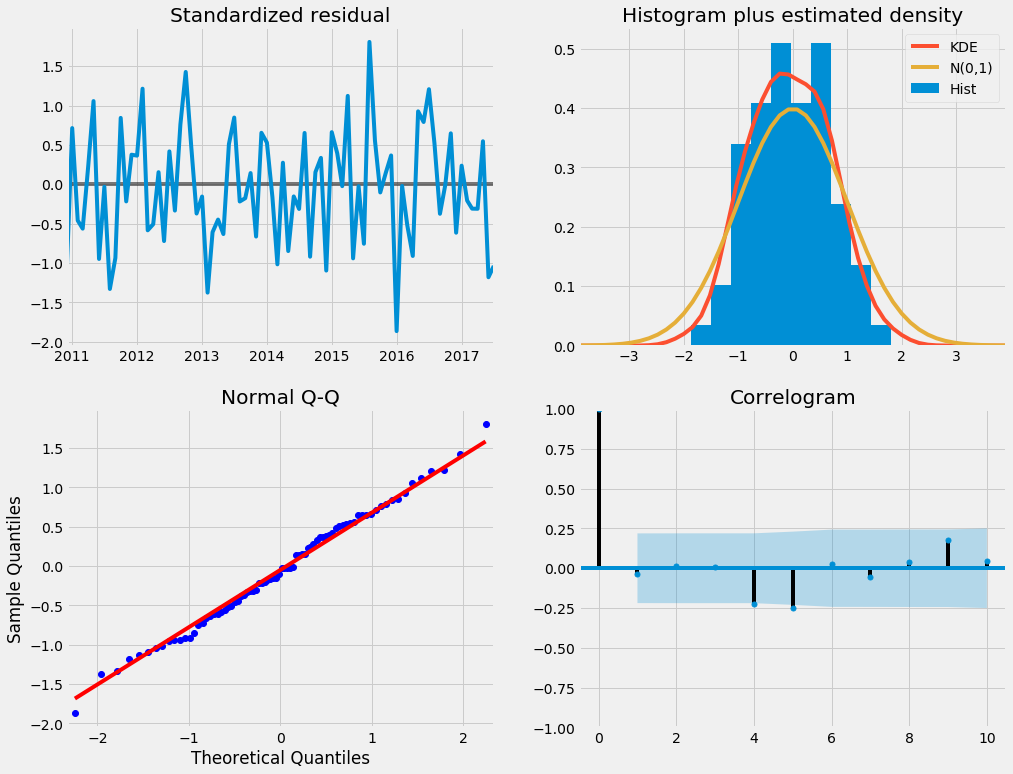

In [232]:
SARIMA_313_311_diff.plot_diagnostics(figsize = (15,12))
plt.show()

In [233]:
pred = SARIMA_313_311_diff.get_prediction(start = datetime.datetime(2015,1,1), dynamic = False)
pred_ci = pred.conf_int()

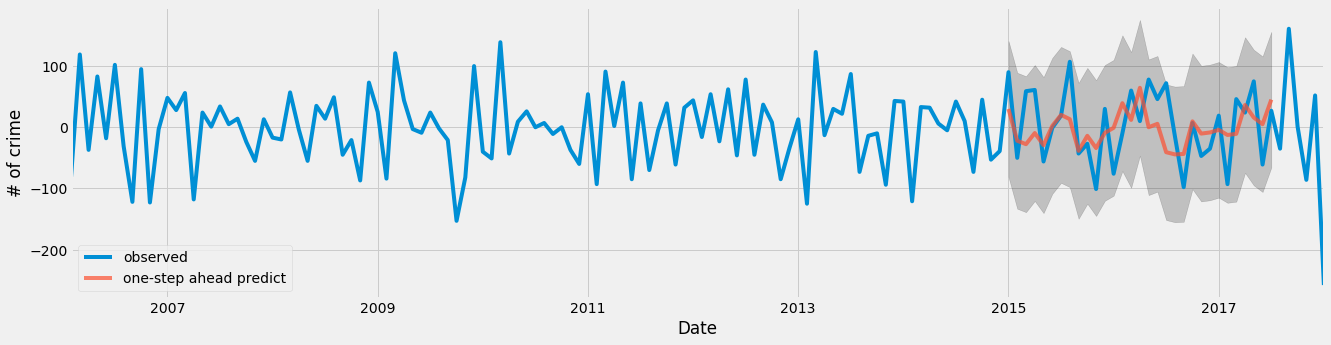

In [234]:
fig = plt.figure(figsize=(20,5))
ax = diff.plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'one-step ahead predict', alpha = .7)

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('# of crime')
plt.legend()
plt.show()

### Decomposition

In [208]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [209]:
decomposition = seasonal_decompose(diff, freq = 12)

In [210]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

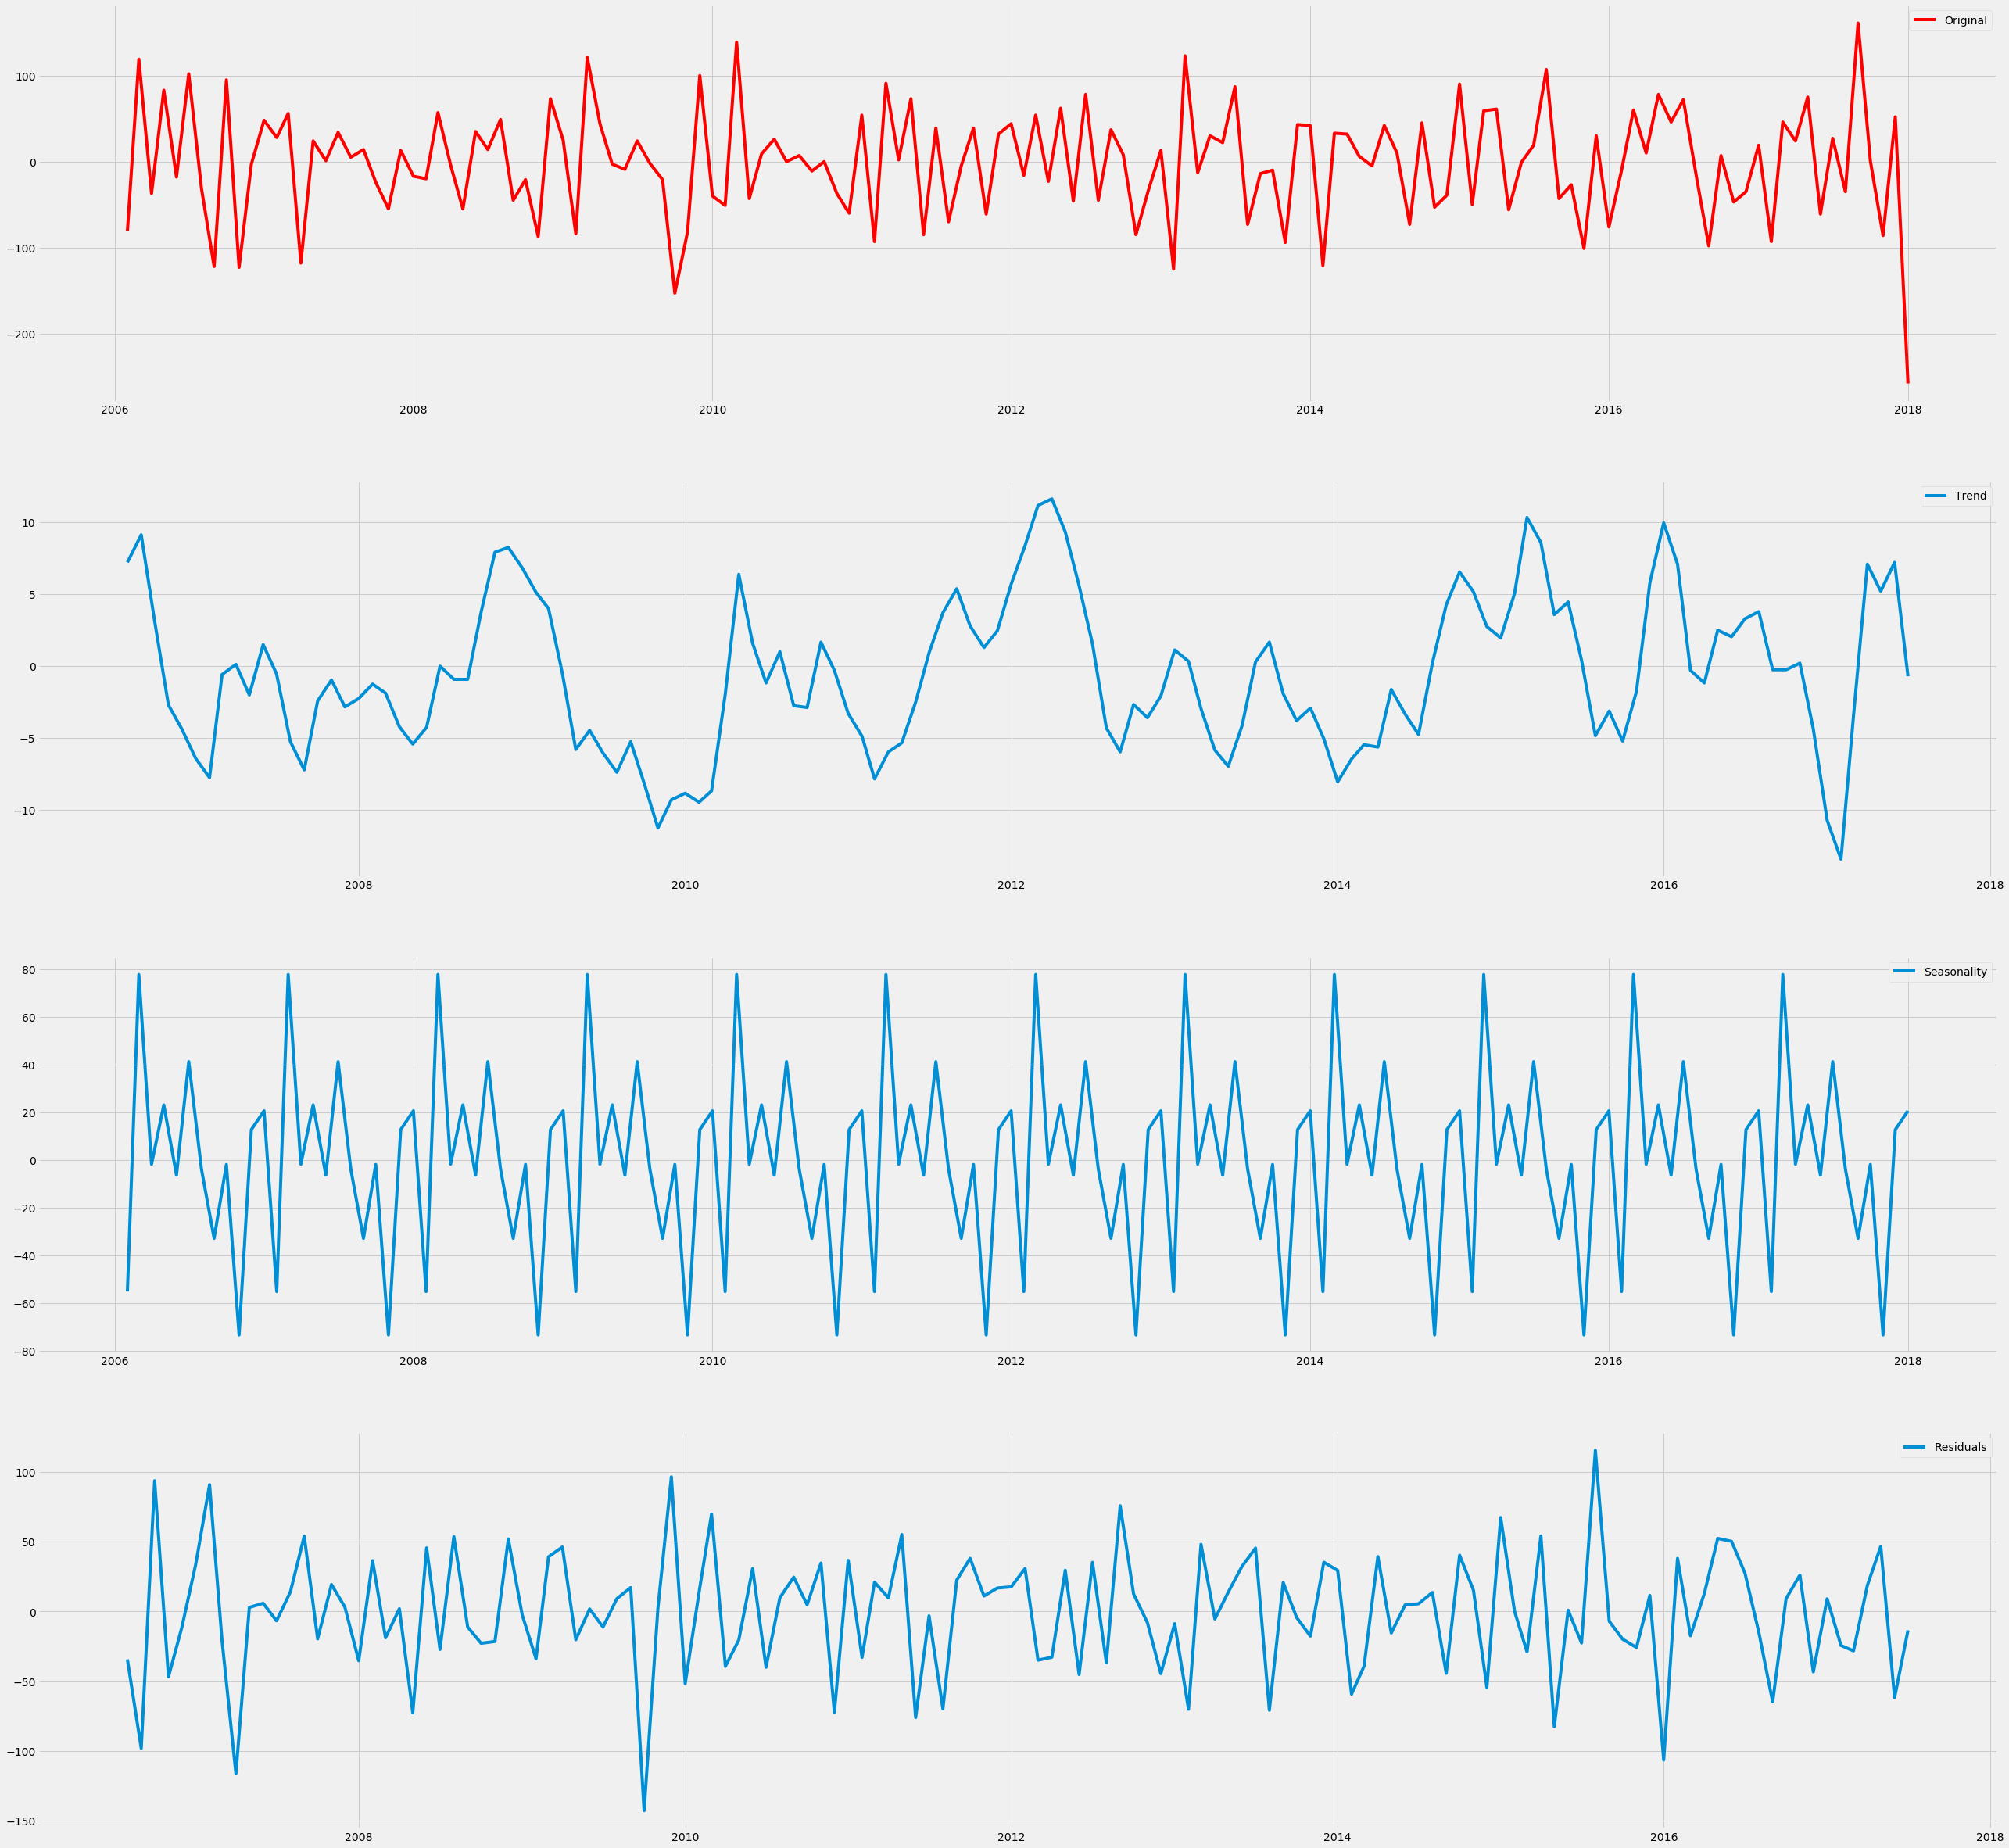

In [211]:
fig=plt.figure(figsize=(40,40))

plt.subplot(4,1,1)
plt.plot(diff, label = 'Original', color = 'red')
plt.legend(loc = 'best')
plt.subplot(4,1,2)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(4,1,3)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(4,1,4)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.show()

In [221]:
diff_resid = residual.dropna()
diff_resid

2006-08-01    -34.370896
2006-09-01    -98.245896
2006-10-01     93.799558
2006-11-01    -46.893624
2006-12-01    -11.329230
2007-01-01     33.810922
2007-02-01     90.935922
2007-03-01    -21.173927
2007-04-01   -116.348169
2007-05-01      2.924558
2007-06-01      5.863952
2007-07-01     -6.681503
2007-08-01     14.087437
2007-09-01     54.087437
2007-10-01    -19.658775
2007-11-01     19.356376
2007-12-01      3.129104
2008-01-01    -35.355745
2008-02-01     36.435922
2008-03-01    -18.882260
2008-04-01      1.985164
2008-05-01    -72.658775
2008-06-01     45.613952
2008-07-01    -27.223169
2008-08-01     53.754104
2008-09-01    -11.204230
2008-10-01    -22.825442
2008-11-01    -21.518624
2008-12-01     52.045770
2009-01-01     -2.439078
                 ...    
2015-02-01      0.144255
2015-03-01    -29.090593
2015-04-01     54.193497
2015-05-01    -82.658775
2015-06-01      0.905619
2015-07-01    -22.639836
2015-08-01    115.670770
2015-09-01     -6.995896
2015-10-01    -19.867109


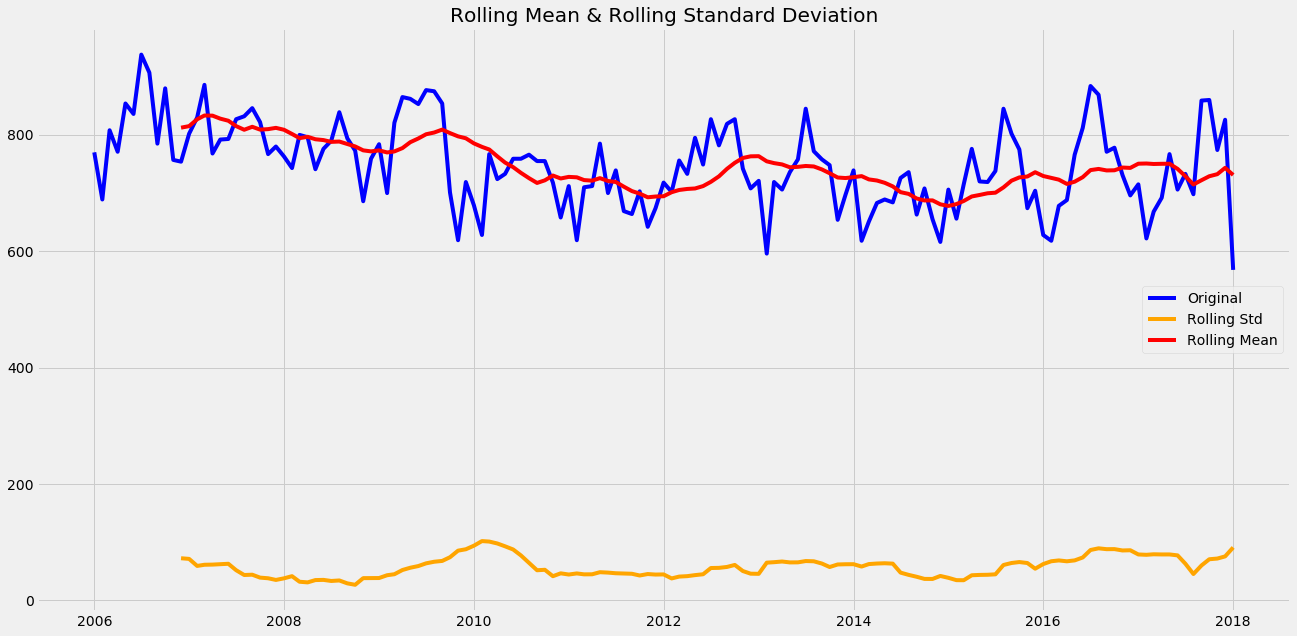

Test Statistic               -7.909107e+00
p-vale                        3.992216e-12
#Lags Used                    6.000000e+00
Mumber of Observation Used    1.250000e+02
Critical Value (1%)          -3.483779e+00
Critical Value (5%)          -2.884954e+00
Critical Value (10%)         -2.579257e+00
dtype: float64


In [222]:
data_info(diff_resid)

In [223]:
modelselection_diff_resid = pd.DataFrame(columns = ['order','seasonal','aic'])

In [224]:
p=q=range(1,4)
d=D=1
pq = list(itertools.product(p,q))
pdq = [(x[0],d,x[1]) for x in pq]
seasonal_pdq = [(x[0],D,x[1],12) for x in pq]

In [225]:
%%time
warnings.filterwarnings('ignore') #ignore warning message

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(diff_resid,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,  
                                            enforce_invertibility = False)
            result = mod.fit().aic
            data = pd.DataFrame([[str(param),str(param_seasonal),result]],
                                columns = modelselection_diff_resid.columns)
            modelselection_diff_resid = modelselection_diff_resid.append(data, ignore_index = True)

        except:
#             print('error')
            continue

Wall time: 7min 2s


In [226]:
modelselection_diff_resid.loc[modelselection_diff_resid['aic'].idxmin()]

order           (3, 1, 3)
seasonal    (3, 1, 1, 12)
aic               860.344
Name: 78, dtype: object

In [228]:
SARIMA_313_311_diff_resid = sm.tsa.statespace.SARIMAX(diff_resid,
                                order = (3,1,3),
                                seasonal_order = (3,1,1,12),
                                enforce_stationarity = False,
                                enforce_invertibility = False).fit()

In [241]:
SARIMA_313_311_diff_resid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Month   No. Observations:                  132
Model:             SARIMAX(3, 1, 3)x(3, 1, 1, 12)   Log Likelihood                -419.172
Date:                            Tue, 13 Feb 2018   AIC                            860.344
Time:                                    22:38:16   BIC                            892.055
Sample:                                08-01-2006   HQIC                           873.230
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4717      0.431     -1.094      0.274      -1.317       0.373
ar.L2          0.2569      0.299      0.859      0.390      -0.329       0.843
ar.L3         -0.1494      0.287     -0.520      0.603      -0.712       0.414
ma.L1         -1.1101      0.446     -2.491      0.013      -1.983      -0.237
ma.L2         -0.6847      0.718     -0.954      0.340      -2.092       0.722
ma.L3          0.8096      0.434      1.867      0.062      -0.040       1.659
ar.S.L12      -0.3012      0.533     -0.565      0.572      -1.346       0.744
ar.S.L24      -0.2323      0.330     -0.705      0.481      -0.879       0.414
ar.S.L36       0.0006      0.051      0.011      0.991      -0.100       0.101
ma.S.L12      -0.4209      0.592     -0.711      0.477      -1.582       0.740
sigma2      3190.9259   1034.546      3.084      0.002    1163.253    5218.598
===================================================================================
Ljung-Box (Q):                       34.43   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.72   Prob(JB):                         0.74
Heteroskedasticity (H):               1.07   Skew:                             0.05
Prob(H) (two-sided):                  0.86   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

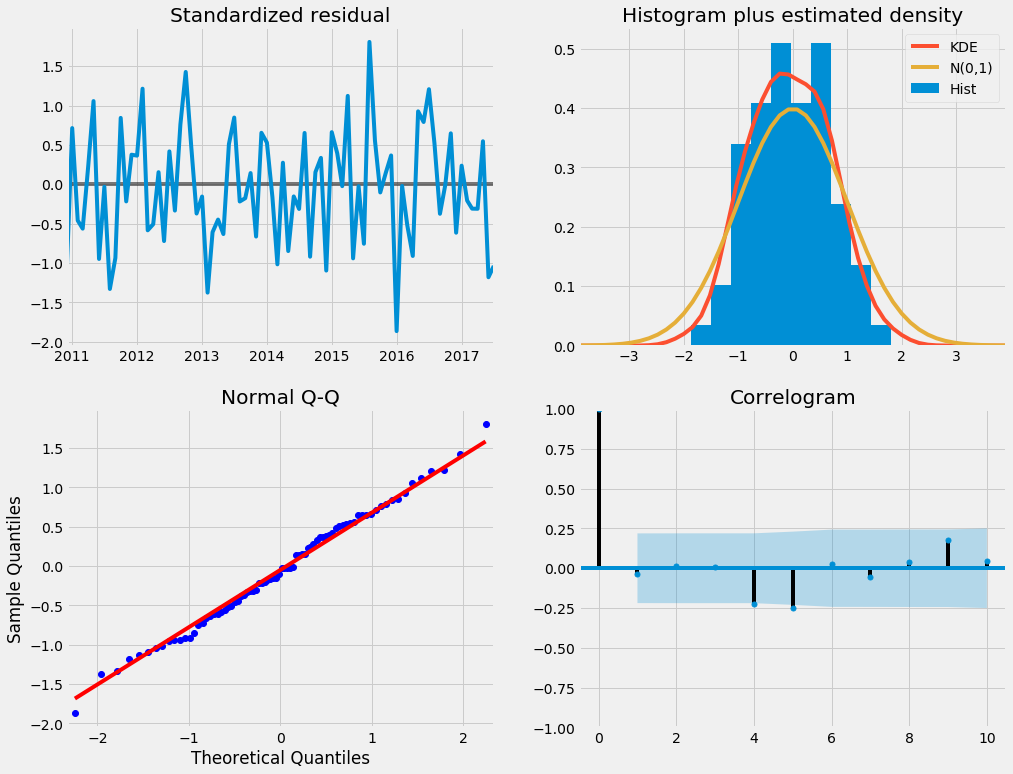

In [242]:
SARIMA_313_311_diff_resid.plot_diagnostics(figsize = (15,12))
plt.show()

In [243]:
pred = SARIMA_313_311_diff_resid.get_prediction(start = datetime.datetime(2015,1,1), dynamic = False)
pred_ci = pred.conf_int()

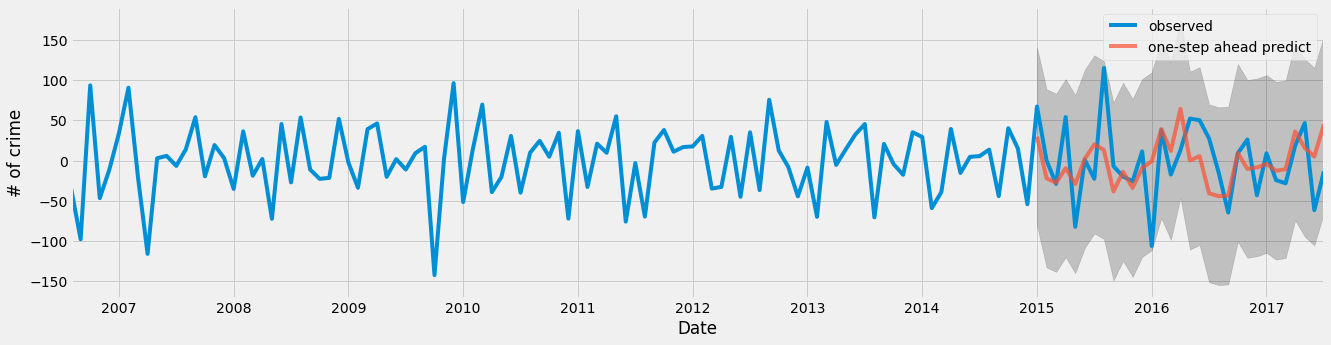

In [244]:
fig = plt.figure(figsize=(20,5))
ax = diff_resid.plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'one-step ahead predict', alpha = .7)

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],
               color = 'k',
               alpha = .2)

ax.set_xlabel('Date')
ax.set_ylabel('# of crime')
plt.legend()
plt.show()

### FB Prophet

In [9]:
from fbprophet import Prophet

In [23]:
df_fb = pd.DataFrame()

In [24]:
df_fb['ds'] = df_month.index
df_fb['y'] = df_month.values

In [25]:
m = Prophet()
m.fit(df_fb)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future = m.make_future_dataframe(periods = 12, freq = 'MS',include_history = True)
future.tail()

,ds
152,2018-09-01
153,2018-10-01
154,2018-11-01
155,2018-12-01
156,2019-01-01


In [31]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
152,2018-09-01,769.138671,704.430219,833.266443
153,2018-10-01,768.410269,707.259052,827.052951
154,2018-11-01,692.318939,627.844249,754.831312
155,2018-12-01,704.625176,644.660211,763.056113
156,2019-01-01,698.386076,636.321068,759.781913


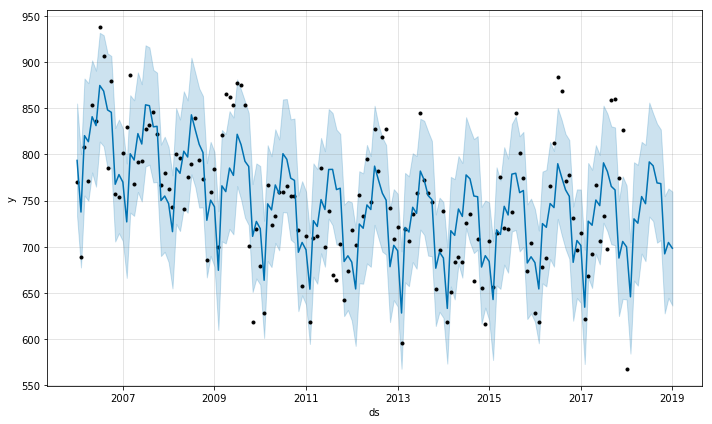

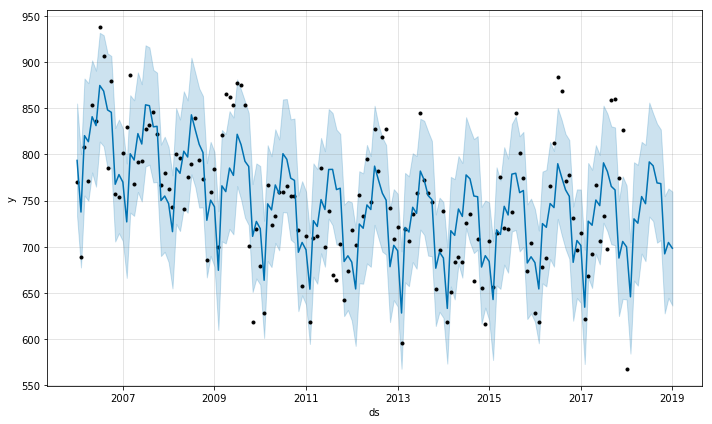

In [32]:
m.plot(forecast)

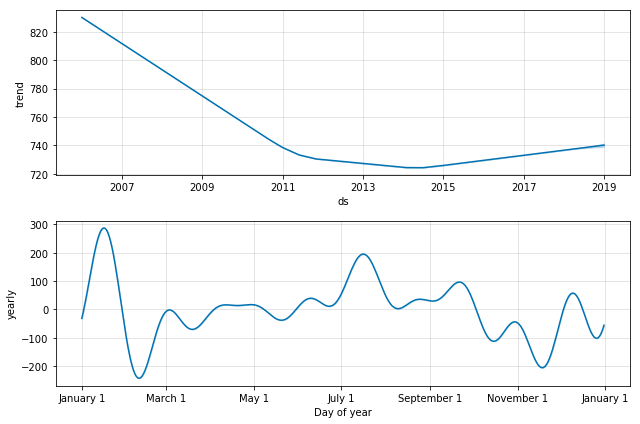

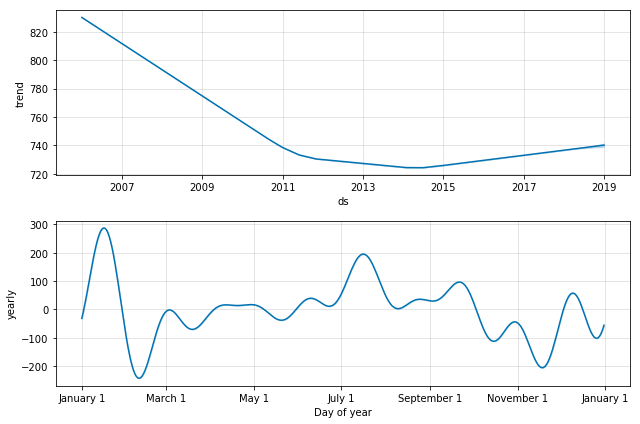

In [33]:
m.plot_components(forecast)

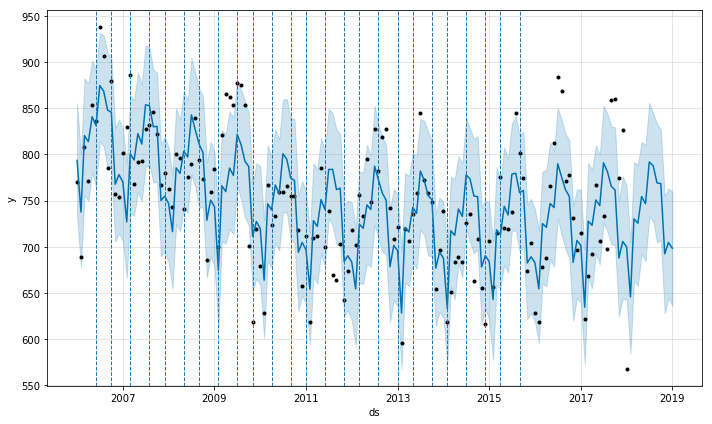

In [36]:
figure = m.plot(forecast)
for point in m.changepoints:
    plt.axvline(point,ls='--',lw = 1)

In [42]:
m.changepoints

5     2006-06-01
9     2006-10-01
14    2007-03-01
19    2007-08-01
23    2007-12-01
28    2008-05-01
32    2008-09-01
37    2009-02-01
42    2009-07-01
46    2009-11-01
51    2010-04-01
56    2010-09-01
60    2011-01-01
65    2011-06-01
70    2011-11-01
74    2012-03-01
79    2012-08-01
84    2013-01-01
88    2013-05-01
93    2013-10-01
97    2014-02-01
102   2014-07-01
107   2014-12-01
111   2015-04-01
116   2015-09-01
Name: ds, dtype: datetime64[ns]

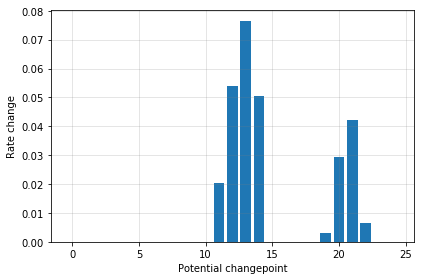

In [40]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor = 'w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)),deltas)
ax.grid(True, which = 'major',c='gray',ls='-',lw = 1,alpha = 0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [52]:
cp = m.changepoints.reset_index()
cp.iloc[np.argmax(deltas)]['ds']


Timestamp('2011-06-01 00:00:00')

In [60]:
m_cp = Prophet(changepoint_prior_scale = 0.8)
forecast_cp = m_cp.fit(df_fb).predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


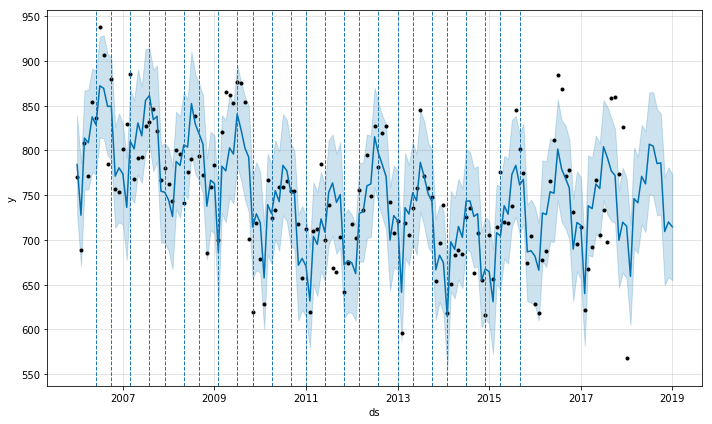

In [61]:
m_cp.plot(forecast_cp)
for point in m.changepoints:
    plt.axvline(point,ls='--',lw = 1)

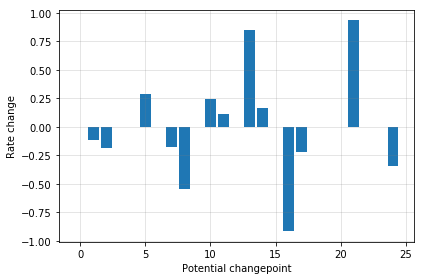

In [62]:
deltas = m_cp.params['delta'].mean(0)
fig = plt.figure(facecolor = 'w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)),deltas)
ax.grid(True, which = 'major',c='gray',ls='-',lw = 1,alpha = 0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [63]:
m.changepoints.shape

(25,)